In [1]:
import importlib
import numpy as np

import Parallel_Run
importlib.reload(Parallel_Run)

import matplotlib.pyplot as plt

Ec = lambda L,N : 3/2*np.log(L/N* np.pi/3)


In [2]:
# gillespie parameter
Nlinker = 20
ell_tot = 10**3
kdiff = 1.
Energy = -15

Nprocess = 30
args = [[ell_tot,Energy,kdiff,np.random.randint(1000000),Nlinker,3] for _ in range(Nprocess)]

# argument of the different classes
cluster_arg = tuple([3.]) # max distance
MSD_arg = () # no argument 
ISF_arg = (0.1,10) # q_norm, q_num_sample
NRG_arg = ()
PCF_arg = (np.sqrt(ell_tot),30,False) # max_distance,numb_bin
PCF_L_arg = (ell_tot,30,False) # max_distance,numb_bin

# Simulation parameters
step_tot = 10**4
check_steps = 10**3
coarse_grained_step = 10**1

In [3]:
#args, step_tot, check_steps,coarse_grained_step,filename,cluster_arg,MSD_arg,ISF_arg,NRG_arg,PCF_arg
Parallel_Run.parallel_evolution(args,step_tot,check_steps,coarse_grained_step,'Test.hdf',
                                cluster_arg,MSD_arg,ISF_arg,NRG_arg,PCF_arg,PCF_L_arg)

In [4]:
import Reader
importlib.reload(Reader)
from Reader import CustomHDF5Reader

In [5]:
Read = CustomHDF5Reader('Test.hdf')
Read.open()
attributes = Read.get_header_attributes()
for key,value in attributes.items():
    print(key + '  '+str(value))
#print(Read.list_groups())
print(Read.list_measurements( Read.list_groups()[0]))
#print(Read.get_measurement_data(Read.list_groups()[0],'Check_Time'))
Read.close()

ell_tot  1000
Energy  -15
kdiff  1.0
seed  460969
Nlinker  20
dimension  3
step_tot  10000
check_steps  1000
coarse_grained_step  10
cluster_max_distance  (3.0,)
MSD_args  ()
ISF_q_norm  (0.1, 10)
ISF_q_num_sample  ()
NRG_args  (31.622776601683793, 30, False)
PCF_max_distance  (1000, 30, False)
['Check_Time', 'Coarse_Time', 'ISF', 'MSD', 'MSD_tot', 'NRG', 'PCF', 'PCF_L', 'cluster', 'moves_1']


In [6]:
from Data_Treatement import *

In [7]:
data = Data_Treatement('Test.hdf',"PCF_L")
#data2 = Data_Treatement('Test.hdf',"cluster")
#print(len(data2.time.shape))

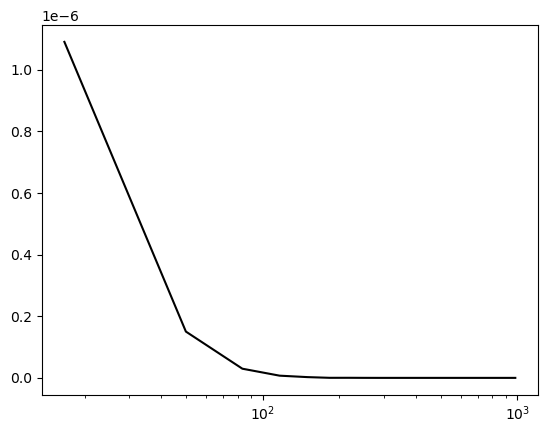

In [8]:
for i in range(1):#data.data.shape[0]):
    plt.plot(data.data[i,0][:,0],data.data[i,0][:,1],color='black')
#for i in range(data.data.shape[0]):
#    plt.plot(data.data[i,-1][:,0],data.data[i,-1][:,1],color='red')
plt.xscale('log')

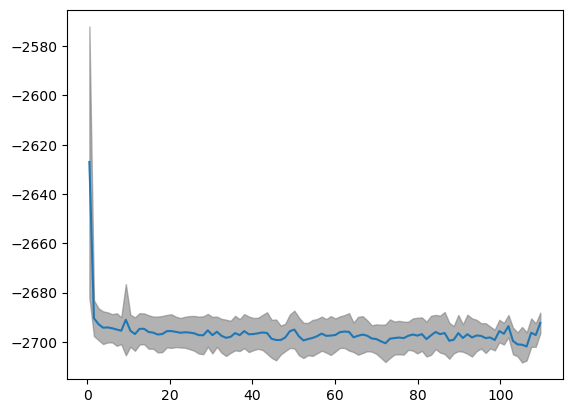

In [7]:
data2.average()
data2.average_data.shape

#for i in range(data2.Nsample):
 #    #for j in range(-1):#data.time[i].shape[0]):
#     plt.plot((data2.time[i]),data2.data[i],color='black',alpha=0.3)
plt.plot(data2.binned_time,data2.average_data)
plt.fill_between(data2.binned_time, data2.average_data-np.sqrt(data2.variance), data2.average_data+np.sqrt(data2.variance), color='gray', alpha=0.6)
#plt.xscale('log')